In [1]:
# %matplotlib widget
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
%reload_ext autoreload

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from tqdm import tqdm

import h5py
import flammkuchen as fl
import seaborn as sns
from matplotlib.cm import ScalarMappable
import scipy
from scipy import stats

In [4]:
from feature_extraction_helper import extract_extrema, moving_average, compute_tbf
from megabouts_helper import labels_cat, color, labels_cat_new, color_ipsi_cont

Color 1: (0.4, 0.7607843137254902, 0.6470588235294118, 1.0)
Color 2: (0.9058823529411765, 0.5411764705882353, 0.7647058823529411, 1.0)


In [5]:
from matplotlib.colors import ListedColormap

cmap_bouts = ListedColormap(color)

In [6]:
master_path = Path(Path(r'\\portulab.synology.me\data\Kata\Figures_Paper\Koetter-et-al_data\Testdata') / 'Raw_Data')
out_path = Path(master_path/'Processed_Data')
fish_paths = list(master_path.glob('*f[0-9]*'))
fish_paths

[WindowsPath('//portulab.synology.me/data/Kata/Figures_Paper/Koetter-et-al_data/Testdata/Raw_Data/240423_f0')]

In [7]:
fish= 0
fish_id =  fish_paths[fish].name
exp_name = 'testfish'
fish_id, exp_name


('240423_f0', 'testfish')

In [8]:
save_data_path = out_path

In [9]:
## tail, left fin, right fin

traces =  fl.load(out_path / '{}_tensor.h5'.format(fish_id))
traces.shape

(460, 3, 50)

In [10]:
save_figure_path = out_path

In [11]:
dt = 0.25/traces.shape[2]

# Tail Beat Frequencies (new version)

In [12]:
tbf_output_list = []

for fin in range(3):
    extrema_idxs = []

    for trace in traces[:, fin, :]:
        #Identify extrema
        mins, maxs = extract_extrema(trace)

        #Combine and sort indexes. Also, add indexes for first and last timepoints (needed to compute all differentials)
        extrema = np.sort(np.concatenate((np.array(mins), np.array(maxs))))
        extrema = np.insert(extrema, 0, 0)
        extrema = np.append(extrema, trace.shape[-1]-1)

        #Normalize trace to [0,1] range and compute average diff (before and after) for each extrema
        trace_norm = (trace-trace.min())/(trace.max()-trace.min())
        extrema_y = [trace_norm[i] for i in extrema]
        extrema_diff = np.abs(np.diff(extrema_y))
        avg_extrema_diff = moving_average(extrema_diff)

        #Automatically define extrema thresholding for each bout
    #     thr = threshold_otsu(avg_extrema_diff)
        #Or set one manually
        thr = 0.2
        #Append extrema only if their average change is larger than the threshold
        extrema_idxs.append(extrema[1:-1][avg_extrema_diff > thr])

        
    ### COMPUTE TBFs ###
    min_valid_tps = 5
    idxs = np.arange(traces.shape[2]) 

    tbf_output = np.full((traces.shape[0], idxs.shape[0]), np.nan) #    tbf_output = np.full(idxs.shape[0], 0)

    for i, extrema in enumerate(extrema_idxs):
        valid_idxs = idxs[np.logical_and(idxs >= min(extrema), idxs < max(extrema))]

        if len(valid_idxs) > min_valid_tps:
            time_diffs = (np.array([x - extrema[i - 1] for i, x in enumerate(extrema)][1:]) * dt)
            binned_tps = np.digitize(valid_idxs, extrema) - 1
            instant_time_diff = np.array([time_diffs[i] for i in binned_tps])
            tbf = (1 / instant_time_diff) / 2
            tbf_output[i, valid_idxs[0] : valid_idxs[-1] + 1] = tbf
        else:
            pass
        
    tbf_output_list.append(tbf_output)
    
tbf_output = np.stack(tbf_output_list)
fl.save(save_data_path/ '{}_tbf_output.h5'.format(fish_id), tbf_output)

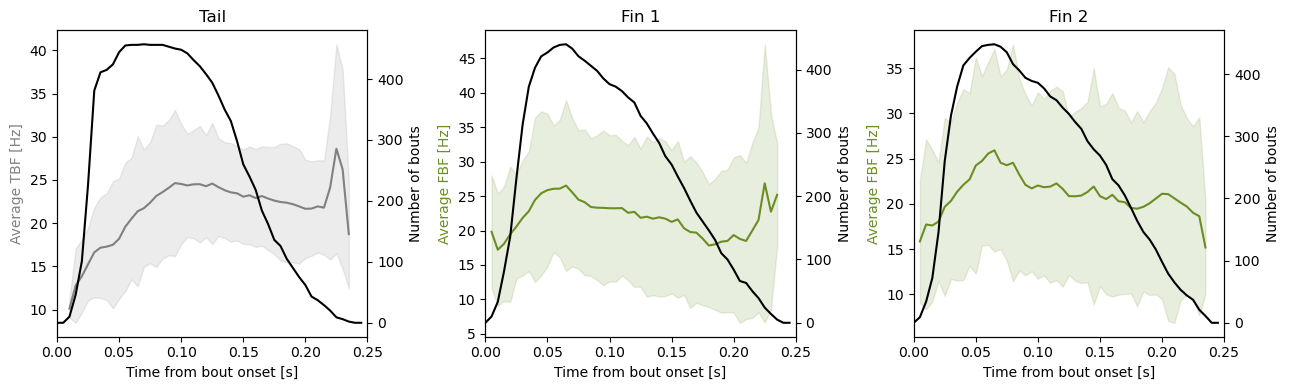

In [17]:
fig, ax = plt.subplots(1, 3, figsize=(13,4), sharey=False)

for i, (fin, title, col) in enumerate(zip(range(3), ['Tail', 'Fin 1', 'Fin 2'], ['gray', 'olivedrab', 'olivedrab'])):

    tbf_mean = np.nanmean(tbf_output[fin], 0)
    tbf_std = np.nanstd(tbf_output[fin], 0)
    tps = np.arange(tbf_mean.shape[0])*dt

    ax[i].plot(tps, tbf_mean, c=col)
    ax[i].fill_between(tps, tbf_mean-tbf_std, tbf_mean+tbf_std, color=col, alpha=.15)
    ax[i].set_xlabel('Time from bout onset [s]')
    ax[i].set_xlim([0, 0.250])
    # ax.set_ylim([10, 60])
    ax[i].set_title(title)

    ax2 = ax[i].twinx()
    ax2.plot(tps, traces.shape[0] - np.isnan(tbf_output[fin]).sum(0), color="black")
    ax2.spines['right'].set_visible(True)
    ax2.set_ylabel("Number of bouts", color="black")


ax[0].set_ylabel('Average TBF [Hz]', color='gray')
for x in ax[1:]:
    x.set_ylabel('Average FBF [Hz]', color='olivedrab')

plt.tight_layout()

fig.savefig(out_path /'plots'/ '{}_TBF_FBF_averages.png'.format(fish_id), dpi=300)
fig.savefig(out_path/'plots' / '{}_TBF_FBF_averages.pdf'.format(fish_id), dpi=300)